In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets.folder import IMG_EXTENSIONS

import pandas as pd
import matplotlib.pyplot as plt
import cv2

import shutil
import PIL
import numpy as np
import pickle
import h5py

In [ ]:
# Ensure compatibility with .jpg files
IMG_EXTENSIONS = ('.jpg', '.jpeg')  # Restrict to jpg and jpeg

# Function to load and preprocess the dataset
def load_dataset(data_dir):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Load datasets for train and validation
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
                   for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

In [ ]:
# Update model training pipeline to ensure .jpg compatibility
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save metrics for visualization
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

In [ ]:
# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


In [ ]:
# Test on a single image
def test_single_image(model, image_path, class_names):
    model.eval()

    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = PIL.Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds[0]]

    print(f"Predicted Class: {predicted_class}")


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Define paths and model
data_dir = '/content/drive/MyDrive/bt_output'
dataloaders, dataset_sizes, class_names = load_dataset(data_dir)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Example: Initialize a pre-trained model for transfer learning
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.5760 Acc: 0.7497
val Loss: 0.2863 Acc: 0.9038

Epoch 1/24
----------
train Loss: 0.2350 Acc: 0.9119
val Loss: 0.2216 Acc: 0.9058

Epoch 2/24
----------
train Loss: 0.1586 Acc: 0.9406
val Loss: 0.1793 Acc: 0.9299

Epoch 3/24
----------
train Loss: 0.0917 Acc: 0.9728
val Loss: 0.2013 Acc: 0.9259

Epoch 4/24
----------
train Loss: 0.0627 Acc: 0.9824
val Loss: 0.1567 Acc: 0.9359

Epoch 5/24
----------
train Loss: 0.0588 Acc: 0.9809
val Loss: 0.1488 Acc: 0.9419

Epoch 6/24
----------
train Loss: 0.0360 Acc: 0.9894
val Loss: 0.1733 Acc: 0.9299

Epoch 7/24
----------
train Loss: 0.0267 Acc: 0.9950
val Loss: 0.1405 Acc: 0.9419

Epoch 8/24
----------
train Loss: 0.0245 Acc: 0.9950
val Loss: 0.1393 Acc: 0.9459

Epoch 9/24
----------
train Loss: 0.0215 Acc: 0.9970
val Loss: 0.1347 Acc: 0.9459

Epoch 10/24
----------
train Loss: 0.0254 Acc: 0.9945
val Loss: 0.1366 Acc: 0.9419

Epoch 11/24
----------
train Loss: 0.0220 Acc: 0.9975
val Loss: 0.1333 Acc: 0.9419

Ep

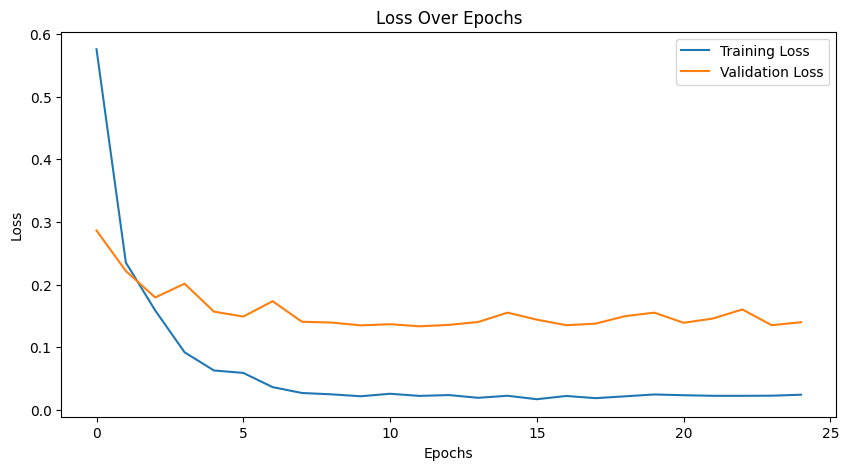

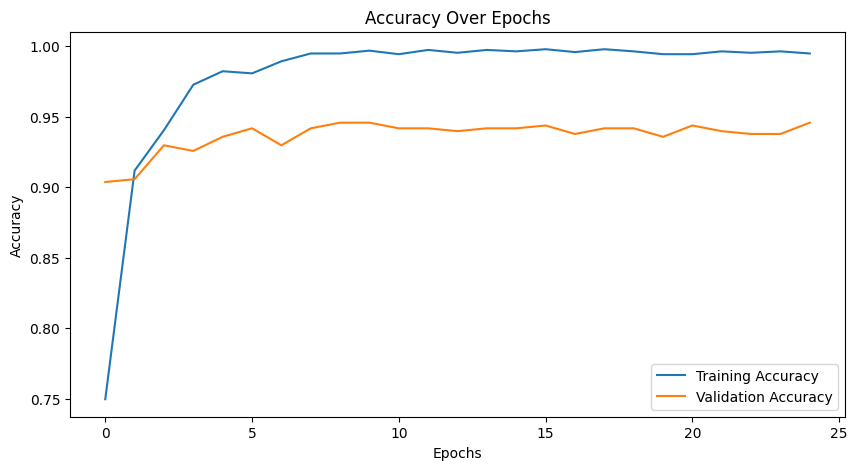

In [ ]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=25)

In [ ]:
# Save the model
save_model_path = '/content/drive/MyDrive/model_ft.pth'
save_model(model_ft, save_model_path)

Model saved to /content/drive/MyDrive/model_ft.pth


In [ ]:
# Test on a single image
image_path = input()
test_single_image(model_ft, image_path, class_names)

/content/drive/MyDrive/bt_output/val/1/m (124).jpg
Predicted Class: 1


In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.6 MB/s eta 0:00:00


In [ ]:
import os
import time
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets.folder import IMG_EXTENSIONS

import pandas as pd
import matplotlib.pyplot as plt
import cv2

import shutil
import PIL
import numpy as np
import pickle
import h5py

# PennyLane
import pennylane as qml
from pennylane import numpy as pnp

In [ ]:
# Ensure compatibility with .jpg files
IMG_EXTENSIONS = ('.jpg', '.jpeg')  # Restrict to jpg and jpeg

# Quantum Circuit Parameters
n_qubits = 4  # Number of qubits
q_depth = 6  # Depth of the quantum circuit

# Define the quantum device
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
# Quantum Neural Network
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    def H_layer(n):
        for wire in range(n):
            qml.Hadamard(wires=wire)

    def RY_layer(params):
        for wire in range(len(params)):
            qml.RY(params[wire], wires=wire)

    def entangling_layer(n):
        for wire in range(n - 1):
            qml.CNOT(wires=[wire, wire + 1])
        qml.CNOT(wires=[n - 1, 0])

    H_layer(n_qubits)
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

# Quantum Layer
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.q_weights = nn.Parameter(torch.rand(q_depth * n_qubits))

    def forward(self, x):
        # Convert each output from quantum_net (tuple) to a tensor and ensure dtype matches the model
        q_out = torch.stack([
            torch.tensor(quantum_net(x[i], self.q_weights), device=x.device, dtype=x.dtype)
            for i in range(x.shape[0])
        ])
        return q_out

In [ ]:
# Function to load and preprocess the dataset
def load_dataset(data_dir):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Load datasets for train and validation
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
                   for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

In [ ]:
# Update model training pipeline to ensure .jpg compatibility
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save metrics for visualization
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model


In [ ]:
# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [ ]:
# Test on a single image
def test_single_image(model, image_path, class_names):
    model.eval()

    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = PIL.Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds[0]]

    print(f"Predicted Class: {predicted_class}")

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Define paths and model
data_dir = '/content/drive/MyDrive/bt_output'
dataloaders, dataset_sizes, class_names = load_dataset(data_dir)

In [ ]:
# Example: Initialize a hybrid classical-quantum model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.conv = torchvision.models.resnet18(pretrained=True)
        num_ftrs = self.conv.fc.in_features
        self.conv.fc = nn.Linear(num_ftrs, n_qubits)
        self.q_layer = QuantumLayer()
        self.fc = nn.Linear(n_qubits, len(class_names))

    def forward(self, x):
        x = self.conv(x)
        x = self.q_layer(x)
        x = self.fc(x)
        return x

In [ ]:
model_ft = HybridModel().to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 1.1140 Acc: 0.3399
val Loss: 1.1176 Acc: 0.3287

Epoch 1/24
----------
train Loss: 1.1076 Acc: 0.3359
val Loss: 1.1058 Acc: 0.3447

Epoch 2/24
----------
train Loss: 1.1020 Acc: 0.3449
val Loss: 1.1010 Acc: 0.3527

Epoch 3/24
----------
train Loss: 1.0997 Acc: 0.3394
val Loss: 1.0960 Acc: 0.3487

Epoch 4/24
----------
train Loss: 1.0961 Acc: 0.3439
val Loss: 1.0949 Acc: 0.3327

Epoch 5/24
----------
train Loss: 1.0948 Acc: 0.3540
val Loss: 1.0934 Acc: 0.3547

Epoch 6/24
----------
train Loss: 1.0922 Acc: 0.3640
val Loss: 1.0914 Acc: 0.3647

Epoch 7/24
----------
train Loss: 1.0924 Acc: 0.3640
val Loss: 1.0916 Acc: 0.3768

Epoch 8/24
----------
train Loss: 1.0928 Acc: 0.3550
val Loss: 1.0907 Acc: 0.3788

Epoch 9/24
----------
train Loss: 1.0922 Acc: 0.3555
val Loss: 1.0917 Acc: 0.3687

Epoch 10/24
----------
train Loss: 1.0914 Acc: 0.3711
val Loss: 1.0896 Acc: 0.3928

Epoch 11/24
----------
train Loss: 1.0910 Acc: 0.3751
val Loss: 1.0900 Acc: 0.3747

Ep

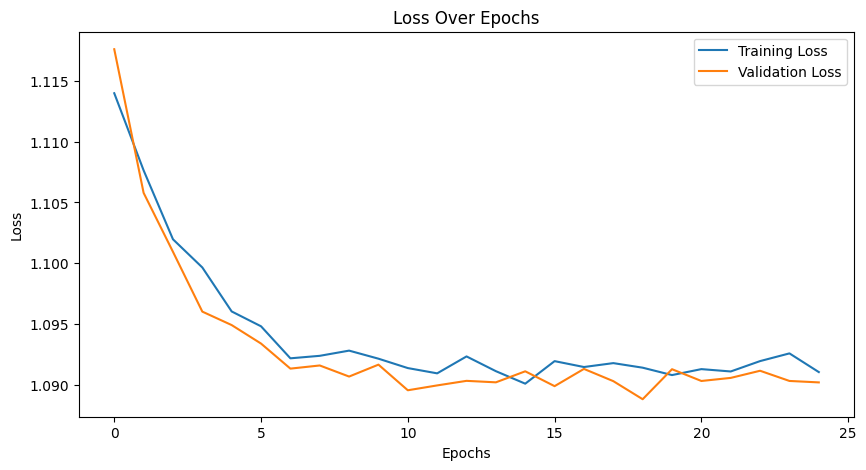

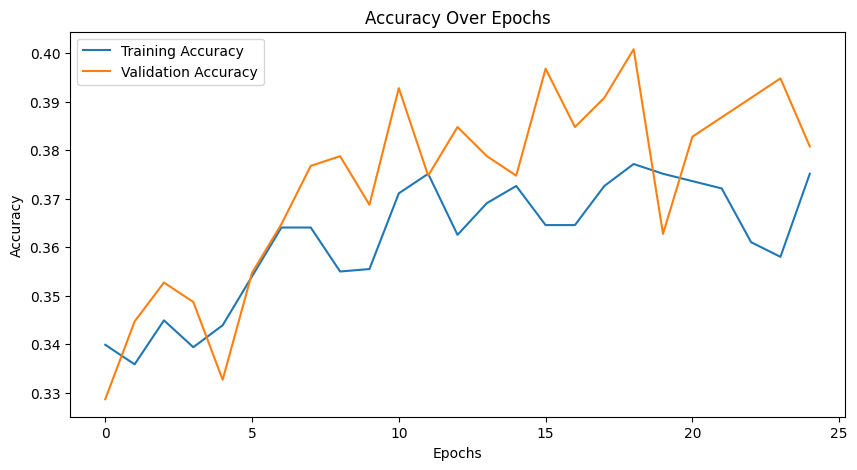

In [ ]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=25)

In [ ]:
# Save the model
save_model_path = '/content/drive/MyDrive/model_ft.pth'
save_model(model_ft, save_model_path)

Model saved to /content/drive/MyDrive/model_ft.pth


In [ ]:
# Test on a single image
image_path = input()
test_single_image(model_ft, image_path, class_names)
